# Anticipez les besoins en consommation de bâtiments - Ville de SEATTLE
# Notebook de prédiction 1 - Consommation en énergie


### Ce qu'il faut faire :

#### 1) analyse exploratoire 
déja fait dans le précédent notebook
#### 2) prédiction émission CO2
différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi. 
Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.
https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what

#### 3) prédiction consommation totale
différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.


# <a name="C1">1. Set up environnement</a>

In [23]:
#Import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import isnan
import scipy.stats
%matplotlib inline
from numpy import arange
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import shap

#Réglages d'affichage
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 2000)

# Rappel du thème utilisé
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [2]:
#Import des données
data = pd.read_csv('C:/Users/Me/Documents/1- DATA SCIENCE/datapostcleaning.csv')
data2 = pd.read_csv('C:/Users/Me/Documents/1- DATA SCIENCE/datapostcleaning2.csv')

In [3]:
data.set_index('OSEBuildingID',inplace=True)
data2.set_index('OSEBuildingID',inplace=True)
#stock ENERGYSTARScore
ENERGYSTARScore=data.ENERGYSTARScore
#drop ENERGYSTARScore
data.drop(columns='ENERGYSTARScore',inplace=True)
data2.drop(columns='ENERGYSTARScore',inplace=True)

# X avec les vars et y à prédire

In [4]:
data

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding_s,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse_kBtu,TotalGHGEmissions,BuildingAge,ElectricityUse,SteamUse,NaturalGasUse,NbEnergies,PrimaryPropertyType_Administrative,PrimaryPropertyType_Education,PrimaryPropertyType_Food Service,PrimaryPropertyType_Healthcare,PrimaryPropertyType_Hotel/Residential,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Public Services,PrimaryPropertyType_Retail,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse/Storage,LargestPropertyUseType_Administrative,LargestPropertyUseType_Education,LargestPropertyUseType_Entertainment,LargestPropertyUseType_Fitness Center/Health Club/Gym,LargestPropertyUseType_Food Service,LargestPropertyUseType_Healthcare,LargestPropertyUseType_Hotel/Residential,LargestPropertyUseType_Industrial/Manufacturing,LargestPropertyUseType_Laboratory,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Other - Recreation,LargestPropertyUseType_Other - Utility,LargestPropertyUseType_Parking,LargestPropertyUseType_Pre-school/Daycare,LargestPropertyUseType_Prison/Incarceration,LargestPropertyUseType_Public Services,LargestPropertyUseType_Retail,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Warehouse/Storage,LargestPropertyUseType_unknown,SecondLargestPropertyUseType_Administrative,SecondLargestPropertyUseType_Education,SecondLargestPropertyUseType_Entertainment,SecondLargestPropertyUseType_Fitness Center/Health Club/Gym,SecondLargestPropertyUseType_Food Service,SecondLargestPropertyUseType_Healthcare,SecondLargestPropertyUseType_Hotel/Residential,SecondLargestPropertyUseType_Industrial/Manufacturing,SecondLargestPropertyUseType_Laboratory,SecondLargestPropertyUseType_Multifamily Housing,SecondLargestPropertyUseType_Office,SecondLargestPropertyUseType_Other,SecondLargestPropertyUseType_Other - Recreation,SecondLargestPropertyUseType_Parking,SecondLargestPropertyUseType_Pre-school/Daycare,SecondLargestPropertyUseType_Public Services,SecondLargestPropertyUseType_Retail,SecondLargestPropertyUseType_Supermarket/Grocery Store,SecondLargestPropertyUseType_Swimming Pool,SecondLargestPropertyUseType_Warehouse/Storage,SecondLargestPropertyUseType_unknown,ThirdLargestPropertyUseType_Administrative,ThirdLargestPropertyUseType_Education,ThirdLargestPropertyUseType_Entertainment,ThirdLargestPropertyUseType_Fitness Center/Health Club/Gym,ThirdLargestPropertyUseType_Food Service,ThirdLargestPropertyUseType_Healthcare,ThirdLargestPropertyUseType_Hotel/Residential,ThirdLargestPropertyUseType_Industrial/Manufacturing,ThirdLargestPropertyUseType_Laboratory,ThirdLargestPropertyUseType_Multifamily Housing,ThirdLargestPropertyUseType_Office,ThirdLargestPropertyUseType_Other,ThirdLargestPropertyUseType_Other - Recreation,ThirdLargestPropertyUseType_Other - Technology/Science,ThirdLargestPropertyUseType_Parking,ThirdLargestPropertyUseType_Pre-school/Daycare,ThirdLargestPropertyUseType_Public Services,ThirdLargestPropertyUseType_Retail,ThirdLargestPropertyUseType_Supermarket/Grocery Store,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Warehouse/Storage,ThirdLargestPropertyUseType_unknown
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,47.61220,-122.33799,1.0,12,88434,0,88434,88434.0,0.0,0.0,7.226362e+06,249.98,89,1,1,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,47.61317,-122.33393,1.0,11,103566,15064,88502,83880.0,15064.0,4622.0,8.387933e+06,295.86,20,1,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [5]:
X = data.copy().drop(columns=['SiteEnergyUse_kBtu','TotalGHGEmissions']).values
X2 = data2.copy().drop(columns=['SiteEnergyUse_kBtu','TotalGHGEmissions']).values
y_energy=data.copy()['SiteEnergyUse_kBtu'].values
y_ghg=data.copy()['TotalGHGEmissions'].values


In [6]:
#on travaille en premier sur SiteEneryUse
y=y_energy
# je fais le choix d'utiliser X2
X=X2

# Standardisation : MinMaxScaler

In [7]:
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
X

array([[0.48159352, 0.48198198, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.48572646, 0.50848675, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.48977418, 0.49079514, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.58487431, 0.35239587, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12420111, 0.57128868, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1713677 , 0.76028202, 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Stockage des résultats

In [8]:
resultats = pd.DataFrame(columns=['Modèle', 'RMSE','nRMSE' ,'R2','MAPE'])

# Régressions Linéraires 
Elastic Net ( Lasso + Ridge évaluation)

### trouver hyperparam

###### on cherche les meilleures valeurs alpha et l1_ratio pour l'elastic net


###### define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
###### define model
ratios = arange(0, 1, 0.025)
alphas = [1e-4,1e-3, 1e-2, 0.1,1]
max_iters=[10000]

###### Define the parameter grid to search
param_grid = {
    'alpha': alphas,
    'l1_ratio': ratios,
    'max_iter' : max_iters
}

###### Create the GridSearchCV object
grid_search = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid, cv=cv, n_jobs=-1)

###### Fit the GridSearchCV object to the data
grid_search.fit(X, y)

###### Print the best hyperparameters
print('Best alpha:', grid_search.best_estimator_.alpha)
print('Best l1_ratio:', grid_search.best_estimator_.l1_ratio)


Résultat de la grid search : Best alpha: 0.001
Best l1_ratio: 0.675

Mean RMSE: 3611133.488 (375862.107)
Mean R2: 0.669 (0.061)
Mean MAPE: 1.007 (0.160)


C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.175e+15, tolerance: 3.342e+12
  model = cd_fast.enet_coordinate_descent(
C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.167e+15, tolerance: 4.730e+12
  model = cd_fast.enet_coordinate_descent(
C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

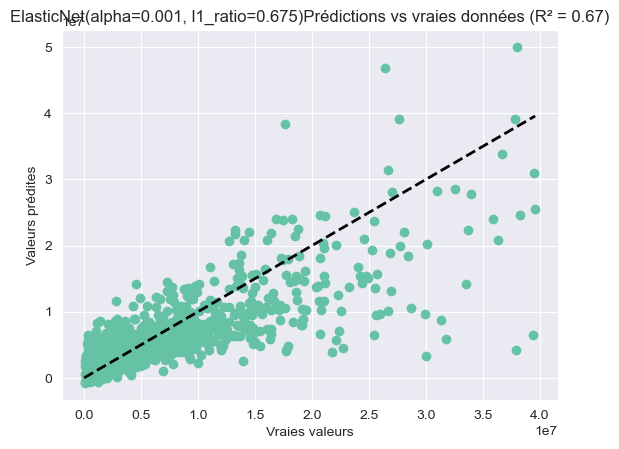

In [9]:
#evaluer le modele elastic net avec les hyperpar trouvés
# define model
model = ElasticNet(alpha=0.001, l1_ratio=0.675)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3)
# evaluate model RMSE
scoresRMSE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scoresRMSE = np.absolute(scoresRMSE)
RMSE_model=np.mean(scoresRMSE)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scoresRMSE), np.std(scoresRMSE)))
# evaluate model R2
scoresR2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
scoresR2 = np.absolute(scoresR2)
R2_model=np.mean(scoresR2)
print('Mean R2: %.3f (%.3f)' % (np.mean(scoresR2), np.std(scoresR2)))
# evaluate model MAPE
scoresMAPE = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scoresMAPE = np.absolute(scoresMAPE)
MAPE_model=np.mean(scoresMAPE)
print('Mean MAPE: %.3f (%.3f)' % (np.mean(scoresMAPE), np.std(scoresMAPE)))


# prediction via cross val
y_pred = cross_val_predict(model, X, y, cv=5)

# Tracer un graphique de dispersion
plt.scatter(y, y_pred)
plt.plot([0, max(y)], [0, max(y)], 'k--', lw=2) # droite d'ajustement
plt.xlabel('Vraies valeurs')
plt.ylabel('Valeurs prédites')
plt.title(str(model) + f'Prédictions vs vraies données (R² = {R2_model:.2f})')
plt.show()

In [10]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(model), round(RMSE_model,3), np.round(RMSE_model/np.mean(y),3),round(R2_model,3),round(MAPE_model,3)]
#affichage des résultats
resultats

,Modèle,RMSE,nRMSE,R2,MAPE
0,"ElasticNet(alpha=0.001, l1_ratio=0.675)",3611133.488,0.716,0.669,1.007


# DummyRegressor¶

Mean RMSE: 6340829.028 (577543.039)
Mean R2: 0.004 (0.006)
Mean MAPE: 2.826 (0.225)


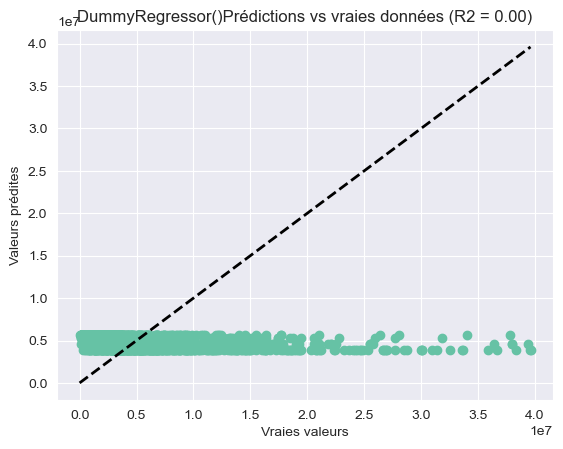

,Modèle,RMSE,nRMSE,R2,MAPE
0,"ElasticNet(alpha=0.001, l1_ratio=0.675)",3611133.488,0.716,0.669,1.007
1,DummyRegressor(),6340829.028,1.258,0.004,2.826


In [11]:
# define model
model = DummyRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3)
# evaluate model RMSE
scoresRMSE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scoresRMSE = np.absolute(scoresRMSE)
RMSE_model=np.mean(scoresRMSE)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scoresRMSE), np.std(scoresRMSE)))
# evaluate model R2
scoresR2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
scoresR2 = np.absolute(scoresR2)
R2_model=np.mean(scoresR2)
print('Mean R2: %.3f (%.3f)' % (np.mean(scoresR2), np.std(scoresR2)))
# evaluate model MAPE
scoresMAPE = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scoresMAPE = np.absolute(scoresMAPE)
MAPE_model=np.mean(scoresMAPE)
print('Mean MAPE: %.3f (%.3f)' % (np.mean(scoresMAPE), np.std(scoresMAPE)))
# prediction via cross val
y_pred = cross_val_predict(model, X, y, cv=5)
# Tracer un graphique de dispersion
plt.scatter(y, y_pred)
plt.plot([0, max(y)], [0, max(y)], 'k--', lw=2) # droite d'ajustement
plt.xlabel('Vraies valeurs')
plt.ylabel('Valeurs prédites')
plt.title(str(model) + f'Prédictions vs vraies données (R2 = {R2_model:.2f})')
plt.show()
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(model), round(RMSE_model,3), np.round(RMSE_model/np.mean(y),3),round(R2_model,3),round(MAPE_model,3)]
#affichage des résultats
resultats

# Linear Regression Classique

Mean RMSE: 3773933.598 (474965.612)
Mean R2: 0.609 (0.096)
Mean MAPE: 0.981 (0.146)


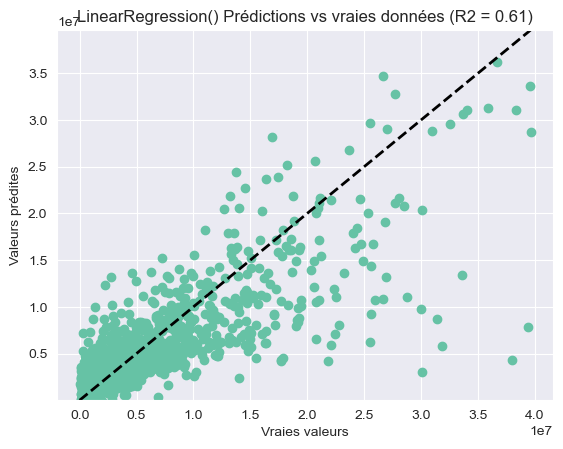

In [12]:
# define model
model = LinearRegression()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3)
# evaluate model RMSE
scoresRMSE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scoresRMSE = np.absolute(scoresRMSE)
RMSE_model=np.mean(scoresRMSE)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scoresRMSE), np.std(scoresRMSE)))
# evaluate model R2
scoresR2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
scoresR2 = np.absolute(scoresR2)
R2_model=np.mean(scoresR2)
print('Mean R2: %.3f (%.3f)' % (np.mean(scoresR2), np.std(scoresR2)))
# evaluate model MAPE
scoresMAPE = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scoresMAPE = np.absolute(scoresMAPE)
MAPE_model=np.mean(scoresMAPE)
print('Mean MAPE: %.3f (%.3f)' % (np.mean(scoresMAPE), np.std(scoresMAPE)))
# prediction via cross val
y_pred = cross_val_predict(model, X, y, cv=5)
# Tracer un graphique de dispersion
plt.scatter(y, y_pred)
plt.plot([0, max(y)], [0, max(y)], 'k--', lw=2) # droite d'ajustement
plt.xlabel('Vraies valeurs')
plt.ylabel('Valeurs prédites')
plt.title(str(model) + f' Prédictions vs vraies données (R2 = {R2_model:.2f})')
ax = plt.gca()
ax.set_ylim([min(y), max(y)])
plt.show()

In [13]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(model), round(RMSE_model,3), np.round(RMSE_model/np.mean(y),3),round(R2_model,3),round(MAPE_model,3)]
#affichage des résultats
resultats

,Modèle,RMSE,nRMSE,R2,MAPE
0,"ElasticNet(alpha=0.001, l1_ratio=0.675)",3611133.488,0.716,0.669,1.007
1,DummyRegressor(),6340829.028,1.258,0.004,2.826
2,LinearRegression(),3773933.598,0.748,0.609,0.981


# Random Forest

## trouver hyperparam

from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [400]
###### Number of features to consider at every split
max_features = ['auto', 'sqrt']
###### Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
###### Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
###### Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
###### Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

###### Use the random grid to search for best hyperparameters
###### First create the base model to tune
rf = RandomForestRegressor()
###### Random search of parameters, using 3 fold cross validation, 
###### search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X, y)

rf_random.best_params_

###### grid search suite aux résultats de la random
param_grid = {
    'bootstrap': [False],
    'max_depth': [40, 60, 80],
    'max_features': [9,10],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [400]}
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

###### Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Résultat de la grid_search (bootstrap=False,max_depth=80,max_features=10,min_samples_leaf=1,
                              min_samples_split=8,n_estimators=300)

## Maintenant on applique

Mean RMSE: 3506088.943 (359147.380)
Mean R2: 0.696 (0.026)
Mean MAPE: 0.804 (0.086)


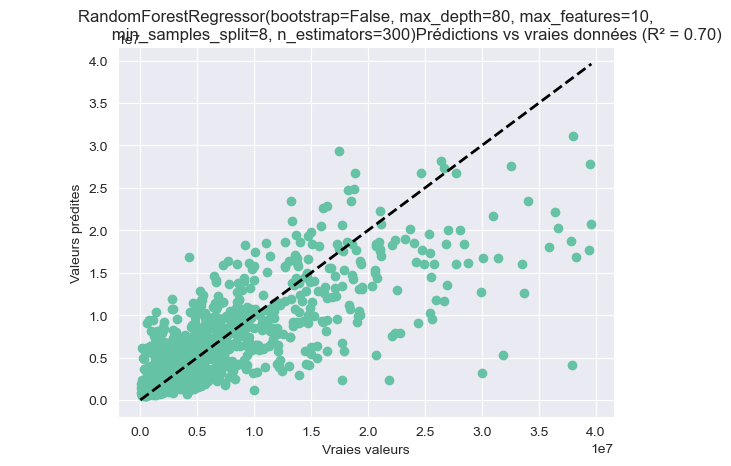

In [14]:
# define model
model = RandomForestRegressor(bootstrap=False,max_depth=80,max_features=10,min_samples_leaf=1,
                              min_samples_split=8,n_estimators=300)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3)
# evaluate model RMSE
scoresRMSE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scoresRMSE = np.absolute(scoresRMSE)
RMSE_model=np.mean(scoresRMSE)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scoresRMSE), np.std(scoresRMSE)))
# evaluate model R2
scoresR2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
scoresR2 = np.absolute(scoresR2)
R2_model=np.mean(scoresR2)
print('Mean R2: %.3f (%.3f)' % (np.mean(scoresR2), np.std(scoresR2)))
# evaluate model MAPE
scoresMAPE = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scoresMAPE = np.absolute(scoresMAPE)
MAPE_model=np.mean(scoresMAPE)
print('Mean MAPE: %.3f (%.3f)' % (np.mean(scoresMAPE), np.std(scoresMAPE)))
# prediction via cross val
y_pred = cross_val_predict(model, X, y, cv=5)
# Tracer un graphique de dispersion
plt.scatter(y, y_pred)
plt.plot([0, max(y)], [0, max(y)], 'k--', lw=2) # droite d'ajustement
plt.xlabel('Vraies valeurs')
plt.ylabel('Valeurs prédites')
plt.title(str(model) + f'Prédictions vs vraies données (R² = {R2_model:.2f})')
plt.show()

In [15]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(model), round(RMSE_model,3), np.round(RMSE_model/np.mean(y),3),round(R2_model,3),round(MAPE_model,3)]
#affichage des résultats
resultats

,Modèle,RMSE,nRMSE,R2,MAPE
0,"ElasticNet(alpha=0.001, l1_ratio=0.675)",3611133.488,0.716,0.669,1.007
1,DummyRegressor(),6340829.028,1.258,0.004,2.826
2,LinearRegression(),3773933.598,0.748,0.609,0.981
3,"RandomForestRegressor(bootstrap=False, max_depth=80, max_features=10,\n min_samples_split=8, n_estimators=300)",3506088.943,0.695,0.696,0.804


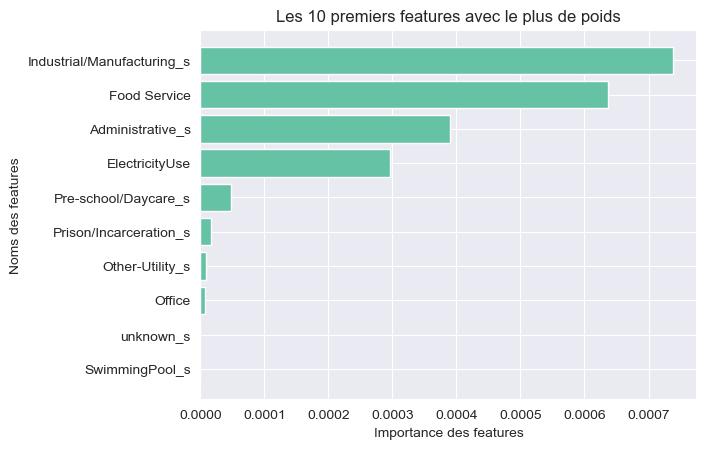

In [16]:
model.fit(X,y)
feature_weights = model.feature_importances_
top10_feature_indexes = np.argsort(feature_weights)[:10]
top10_feature_names = data2.copy().drop(columns=['SiteEnergyUse_kBtu','TotalGHGEmissions']).columns[top10_feature_indexes]
top10_feature_weights = feature_weights[top10_feature_indexes]
plt.barh(top10_feature_names, top10_feature_weights)
plt.title("Les 10 premiers features avec le plus de poids")
plt.xlabel("Importance des features")
plt.ylabel("Noms des features")
plt.show()



# SVM (Séparatrice à Vaste Marge

## Hyperparam

params = {'gamma' : [0.01,0.1,0.35], #coeff kernel,
              'epsilon' : [0.001, 0.1, 1], #erreur tolérée
              'C' : [1,10,100]} #régularisation

grid_svm = GridSearchCV(estimator = SVR(), 
                      param_grid=params,
                      scoring ='neg_root_mean_squared_error',
                      cv=3,verbose=2)

grid_svm.fit(X, y)

grid_svm.best_params_

La grid search me donne à peu près les paramètres par defaut donc je vais utliser la SVR de base. Pour info voici le résultat de ma grid Search : {'C': 100, 'epsilon': 0.001, 'gamma': 0.35}

Mean RMSE: 6854078.079 (400459.769)
Mean R2: 0.167 (0.041)
Mean MAPE: 1.280 (0.137)


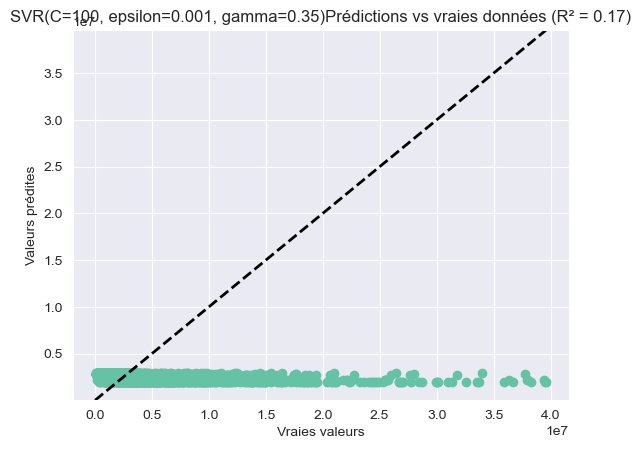

In [17]:
# define model
model = SVR(C=100,epsilon=0.001,gamma=0.35)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3)
# evaluate model RMSE
scoresRMSE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scoresRMSE = np.absolute(scoresRMSE)
RMSE_model=np.mean(scoresRMSE)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scoresRMSE), np.std(scoresRMSE)))
# evaluate model R2
scoresR2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
scoresR2 = np.absolute(scoresR2)
R2_model=np.mean(scoresR2)
print('Mean R2: %.3f (%.3f)' % (np.mean(scoresR2), np.std(scoresR2)))
# evaluate model MAPE
scoresMAPE = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scoresMAPE = np.absolute(scoresMAPE)
MAPE_model=np.mean(scoresMAPE)
print('Mean MAPE: %.3f (%.3f)' % (np.mean(scoresMAPE), np.std(scoresMAPE)))
# prediction via cross val
y_pred = cross_val_predict(model, X, y, cv=5)
# Tracer un graphique de dispersion
plt.scatter(y, y_pred)
plt.plot([0, max(y)], [0, max(y)], 'k--', lw=2) # droite d'ajustement
plt.xlabel('Vraies valeurs')
plt.ylabel('Valeurs prédites')
plt.title(str(model) + f'Prédictions vs vraies données (R² = {R2_model:.2f})')
ax = plt.gca()
ax.set_ylim([min(y), max(y)])
plt.show()

In [18]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(model), round(RMSE_model,3), np.round(RMSE_model/np.mean(y),3),round(R2_model,3),round(MAPE_model,3)]
#affichage des résultats
resultats

,Modèle,RMSE,nRMSE,R2,MAPE
0,"ElasticNet(alpha=0.001, l1_ratio=0.675)",3611133.488,0.716,0.669,1.007
1,DummyRegressor(),6340829.028,1.258,0.004,2.826
2,LinearRegression(),3773933.598,0.748,0.609,0.981
3,"RandomForestRegressor(bootstrap=False, max_depth=80, max_features=10,\n min_samples_split=8, n_estimators=300)",3506088.943,0.695,0.696,0.804
4,"SVR(C=100, epsilon=0.001, gamma=0.35)",6854078.079,1.359,0.167,1.280


# XGBoost

## hyperparam

Pour la recherche des hyperparam j'ai fait différents tests : des grid search mais aussi j'ai testé des paramètres que j'ai trouvé en cherchant sur internet, finalement je garde ceux aves les meilleurs résultats, je conserve ma recherche d'hyperparamètres en texte.

parameters = {'learning_rate': [.001, .01, .1],
              'max_depth': [2, 3, 4,5],
              'reg_alpha': np.logspace(-3, 2, 5),
              'reg_lambda': np.logspace(-3, 2, 5),
              'n_estimators': [500]}
grid_xgboost = GridSearchCV(XGBRegressor(n_jobs=-1),
                        param_grid = parameters,
                      #scoring = 'neg_mean_squared_error',
                        cv = 3,
                        verbose=2)
grid_xgboost.fit(X, y)

grid_xgboost.best_params_

La grid Search me donne ces paramètres : 
{'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 500,
 'reg_alpha': 0.31622776601683794,
 'reg_lambda': 100.0}
 
 Mais comme je trouve mieux avec les miens je les garde

Mean RMSE: 3519258.249 (385135.671)
Mean R2: 0.693 (0.044)
Mean MAPE: 0.795 (0.120)
[11:22:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:22:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:square

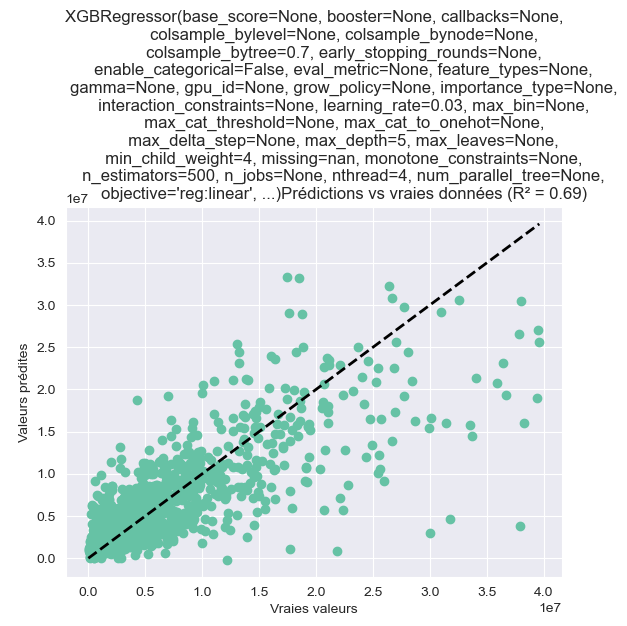

In [19]:
# define model
model = XGBRegressor(n_estimators=500,colsample_bytree=0.7,
 learning_rate=0.03,
 max_depth=5,
 min_child_weight=4,
 nthread=4,
 objective='reg:linear',
subsample=0.7)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3)
# evaluate model RMSE
scoresRMSE = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scoresRMSE = np.absolute(scoresRMSE)
RMSE_model=np.mean(scoresRMSE)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scoresRMSE), np.std(scoresRMSE)))
# evaluate model R2
scoresR2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
scoresR2 = np.absolute(scoresR2)
R2_model=np.mean(scoresR2)
print('Mean R2: %.3f (%.3f)' % (np.mean(scoresR2), np.std(scoresR2)))
# evaluate model MAPE
scoresMAPE = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scoresMAPE = np.absolute(scoresMAPE)
MAPE_model=np.mean(scoresMAPE)
print('Mean MAPE: %.3f (%.3f)' % (np.mean(scoresMAPE), np.std(scoresMAPE)))
# prediction via cross val
y_pred = cross_val_predict(model, X, y, cv=5)
# Tracer un graphique de dispersion
plt.scatter(y, y_pred)
plt.plot([0, max(y)], [0, max(y)], 'k--', lw=2) # droite d'ajustement
plt.xlabel('Vraies valeurs')
plt.ylabel('Valeurs prédites')
plt.title(str(model) + f'Prédictions vs vraies données (R² = {R2_model:.2f})')
plt.show()

In [20]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(model), round(RMSE_model,3), np.round(RMSE_model/np.mean(y),3),round(R2_model,3),round(MAPE_model,3)]
#affichage des résultats
resultats

,Modèle,RMSE,nRMSE,R2,MAPE
0,"ElasticNet(alpha=0.001, l1_ratio=0.675)",3611133.488,0.716,0.669,1.007
1,DummyRegressor(),6340829.028,1.258,0.004,2.826
2,LinearRegression(),3773933.598,0.748,0.609,0.981
3,"RandomForestRegressor(bootstrap=False, max_depth=80, max_features=10,\n min_samples_split=8, n_estimators=300)",3506088.943,0.695,0.696,0.804
4,"SVR(C=100, epsilon=0.001, gamma=0.35)",6854078.079,1.359,0.167,1.280
5,"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=0.7, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=0.03, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=5, max_leaves=None,\n min_child_weight=4, missing=nan, monotone_constraints=None,\n n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,\n objective='reg:linear', ...)",3519258.249,0.698,0.693,0.795


[11:22:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


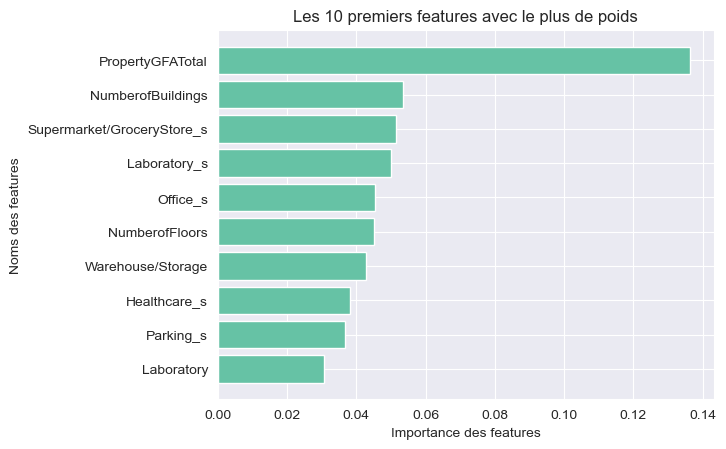

In [21]:
model.fit(X,y)
feature_weights = model.feature_importances_
top10_feature_indexes = np.argsort(feature_weights)[::-1][:10][::-1]
top10_feature_names = data2.copy().drop(columns=['SiteEnergyUse_kBtu','TotalGHGEmissions']).columns[top10_feature_indexes]
top10_feature_weights = feature_weights[top10_feature_indexes]
plt.barh(top10_feature_names, top10_feature_weights)
plt.title("Les 10 premiers features avec le plus de poids")
plt.xlabel("Importance des features")
plt.ylabel("Noms des features")
plt.show()

In [24]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X,feature_names=data2.copy().drop(columns=['SiteEnergyUse_kBtu','TotalGHGEmissions']).columns)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X)

Permutation explainer: 1562it [01:32, 15.46it/s]                                                                       


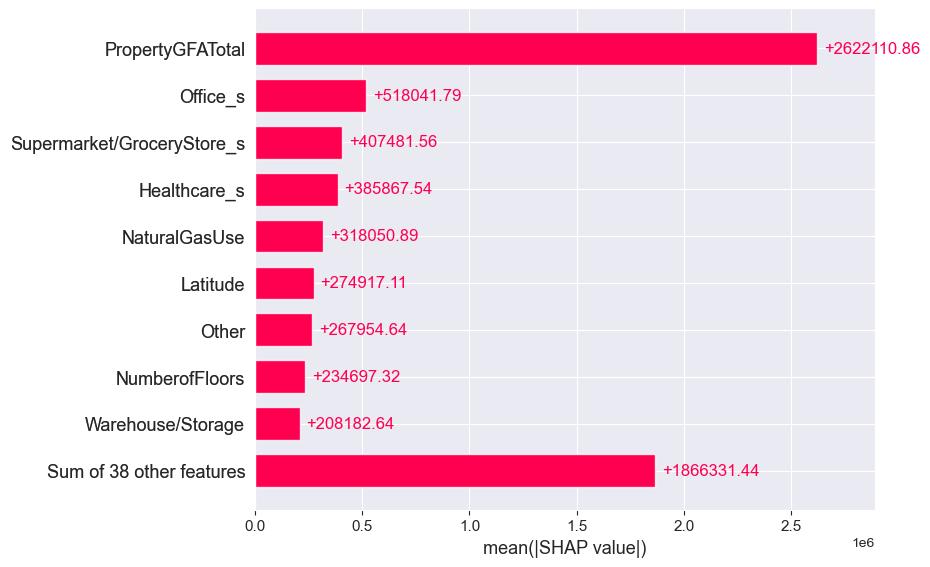

In [25]:
shap.plots.bar(shap_values)

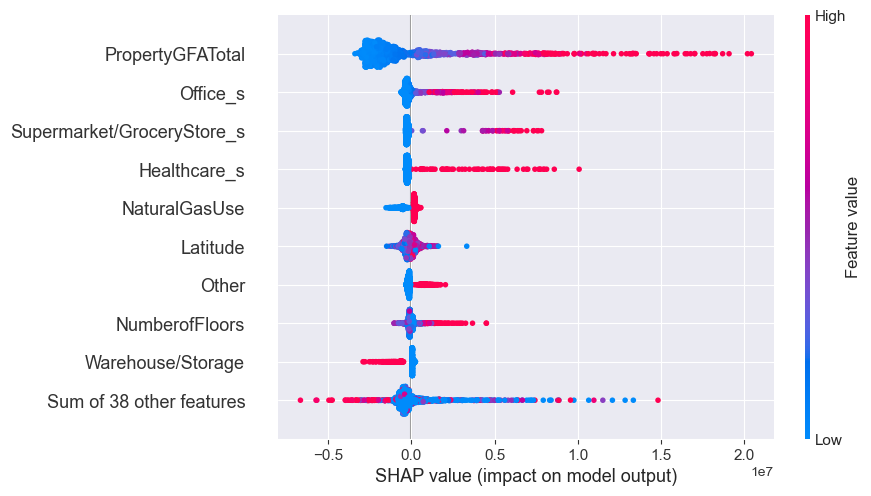

In [26]:
shap.plots.beeswarm(shap_values)

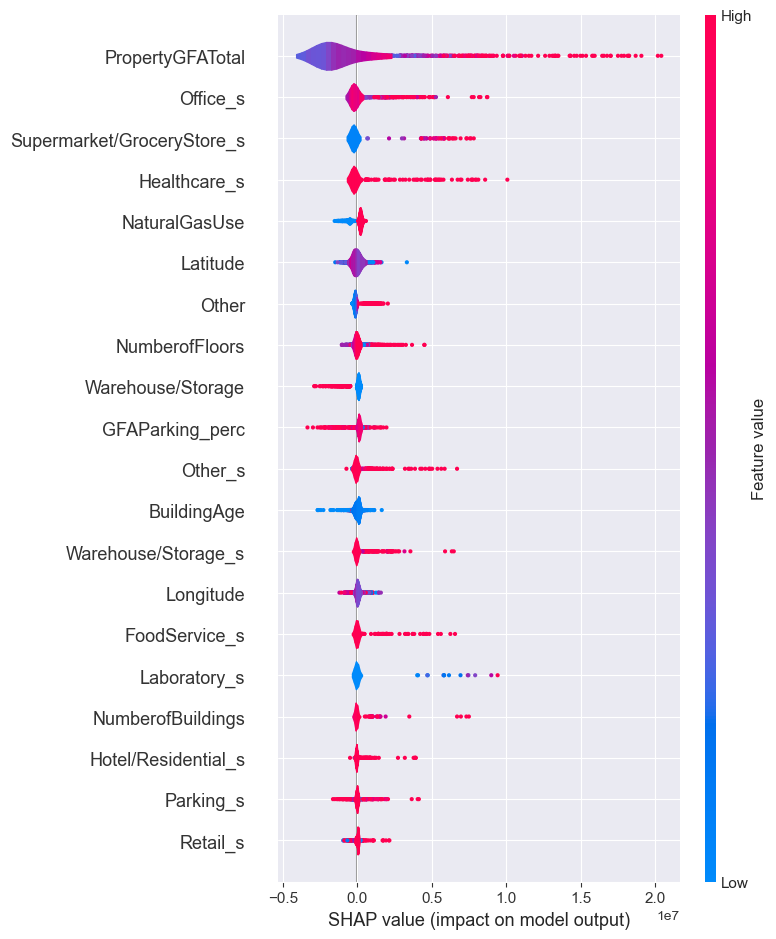

In [27]:
shap.summary_plot(shap_values, plot_type='violin')

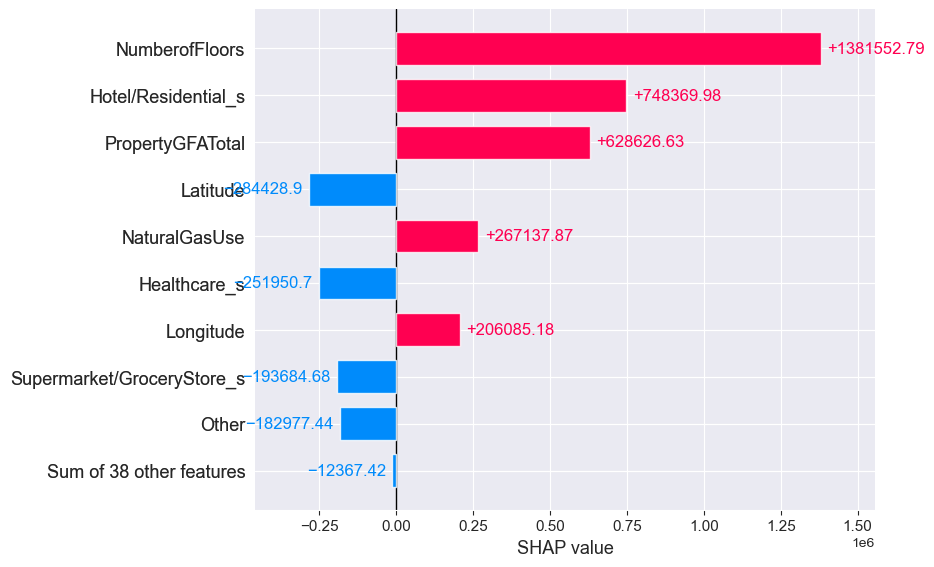

In [28]:
shap.plots.bar(shap_values[0])

# Choix du modèle

Le meilleur modèle semble être
model = XGBRegressor(n_estimators=500,colsample_bytree=0.7,
 learning_rate=0.03,
 max_depth=5,
 min_child_weight=4,
 nthread=4,
 objective='reg:linear',
subsample=0.7)

# Regardons l'utilité, pertinence du ENERGYScore

In [29]:
Xbis = data2.copy().drop(columns=['SiteEnergyUse_kBtu','TotalGHGEmissions'])
Xbis['ENERGYSTARScore']=ENERGYSTARScore
ybis=y.copy()
ybis=pd.DataFrame(ybis)
ybis.set_index(Xbis.index,inplace=True)
ybis.drop(Xbis[Xbis['ENERGYSTARScore']=='unknown'].index,inplace=True)
Xbis.drop(Xbis[Xbis['ENERGYSTARScore']=='unknown'].index,inplace=True)
Xbiswithout=Xbis.drop(columns='ENERGYSTARScore')
#standardisation
scaler = MinMaxScaler()
scaler.fit(Xbis)
Xbis=scaler.transform(Xbis)
scaler.fit(Xbiswithout)
Xbiswithout=scaler.transform(Xbiswithout)

In [30]:
Xbis.shape

(1039, 48)

In [31]:
Xbiswithout.shape

(1039, 47)

In [32]:
ybis=ybis.values

Mean RMSE: 2569723.949 (511946.980)
Mean R2: 0.844 (0.050)
Mean MAPE: 0.425 (0.056)
[11:27:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:square

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


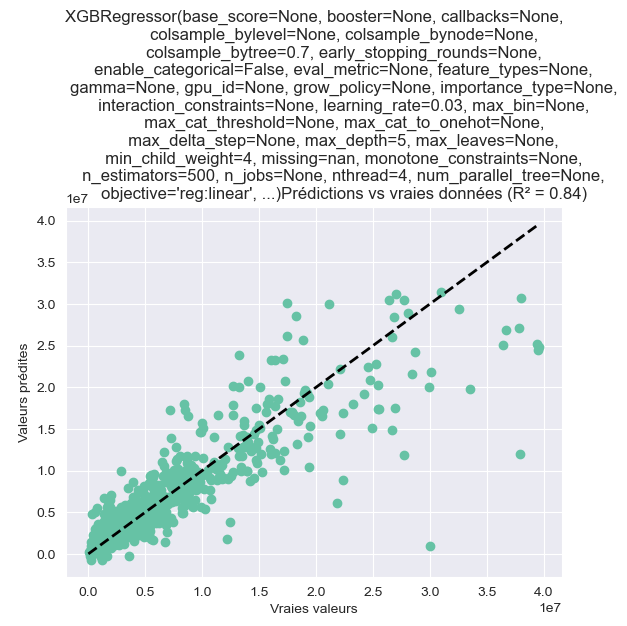

In [33]:
#AVEC ENERGY STAR SCORE 

# define model
model = XGBRegressor(n_estimators=500,colsample_bytree=0.7,
 learning_rate=0.03,
 max_depth=5,
 min_child_weight=4,
 nthread=4,
 objective='reg:linear',
subsample=0.7)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3)
# evaluate model RMSE
scoresRMSE = cross_val_score(model, Xbis, ybis, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scoresRMSE = np.absolute(scoresRMSE)
RMSE_model=np.mean(scoresRMSE)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scoresRMSE), np.std(scoresRMSE)))
# evaluate model R2
scoresR2 = cross_val_score(model, Xbis, ybis, scoring='r2', cv=cv, n_jobs=-1)
scoresR2 = np.absolute(scoresR2)
R2_model=np.mean(scoresR2)
print('Mean R2: %.3f (%.3f)' % (np.mean(scoresR2), np.std(scoresR2)))
# evaluate model MAPE
scoresMAPE = cross_val_score(model, Xbis, ybis, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scoresMAPE = np.absolute(scoresMAPE)
MAPE_model=np.mean(scoresMAPE)
print('Mean MAPE: %.3f (%.3f)' % (np.mean(scoresMAPE), np.std(scoresMAPE)))
# prediction via cross val
y_pred = cross_val_predict(model, Xbis, ybis, cv=5)
# Tracer un graphique de dispersion
plt.scatter(ybis, y_pred)
plt.plot([0, max(ybis)], [0, max(ybis)], 'k--', lw=2) # droite d'ajustement
plt.xlabel('Vraies valeurs')
plt.ylabel('Valeurs prédites')
plt.title(str(model) + f'Prédictions vs vraies données (R² = {R2_model:.2f})')
plt.show()

In [34]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = ['XGboost + ENERGYSTARScore', round(RMSE_model,3), np.round(RMSE_model/np.mean(y),3),round(R2_model,3),round(MAPE_model,3)]
#affichage des résultats
resultats

,Modèle,RMSE,nRMSE,R2,MAPE
0,"ElasticNet(alpha=0.001, l1_ratio=0.675)",3611133.488,0.716,0.669,1.007
1,DummyRegressor(),6340829.028,1.258,0.004,2.826
2,LinearRegression(),3773933.598,0.748,0.609,0.981
3,"RandomForestRegressor(bootstrap=False, max_depth=80, max_features=10,\n min_samples_split=8, n_estimators=300)",3506088.943,0.695,0.696,0.804
4,"SVR(C=100, epsilon=0.001, gamma=0.35)",6854078.079,1.359,0.167,1.280
5,"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=0.7, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=0.03, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=5, max_leaves=None,\n min_child_weight=4, missing=nan, monotone_constraints=None,\n n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,\n objective='reg:linear', ...)",3519258.249,0.698,0.693,0.795
6,XGboost + ENERGYSTARScore,2569723.949,0.510,0.844,0.425


Mean RMSE: 3305370.579 (536140.246)
Mean R2: 0.731 (0.077)
Mean MAPE: 0.620 (0.098)
[11:27:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:27:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:square

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


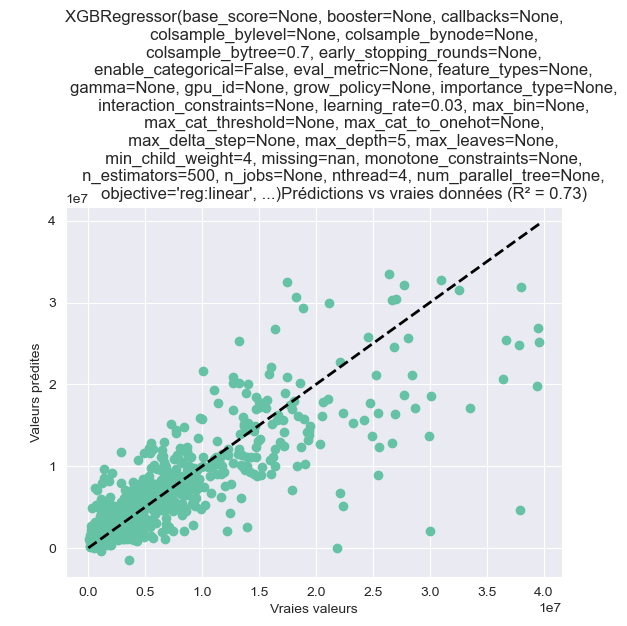

In [35]:
#SANS ENERGY STAR SCORE

# define model
model = XGBRegressor(n_estimators=500,colsample_bytree=0.7,
 learning_rate=0.03,
 max_depth=5,
 min_child_weight=4,
 nthread=4,
 objective='reg:linear',
subsample=0.7)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3)
# evaluate model RMSE
scoresRMSE = cross_val_score(model, Xbiswithout, ybis, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scoresRMSE = np.absolute(scoresRMSE)
RMSE_model=np.mean(scoresRMSE)
print('Mean RMSE: %.3f (%.3f)' % (np.mean(scoresRMSE), np.std(scoresRMSE)))
# evaluate model R2
scoresR2 = cross_val_score(model, Xbiswithout, ybis, scoring='r2', cv=cv, n_jobs=-1)
scoresR2 = np.absolute(scoresR2)
R2_model=np.mean(scoresR2)
print('Mean R2: %.3f (%.3f)' % (np.mean(scoresR2), np.std(scoresR2)))
# evaluate model MAPE
scoresMAPE = cross_val_score(model, Xbiswithout, ybis, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
scoresMAPE = np.absolute(scoresMAPE)
MAPE_model=np.mean(scoresMAPE)
print('Mean MAPE: %.3f (%.3f)' % (np.mean(scoresMAPE), np.std(scoresMAPE)))
# prediction via cross val
y_pred = cross_val_predict(model, Xbiswithout, ybis, cv=5)
# Tracer un graphique de dispersion
plt.scatter(ybis, y_pred)
plt.plot([0, max(ybis)], [0, max(ybis)], 'k--', lw=2) # droite d'ajustement
plt.xlabel('Vraies valeurs')
plt.ylabel('Valeurs prédites')
plt.title(str(model) + f'Prédictions vs vraies données (R² = {R2_model:.2f})')
plt.show()

In [36]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = ['XGboost + sans ENERGYSTARScore', round(RMSE_model,3), np.round(RMSE_model/np.mean(y),3),round(R2_model,3),round(MAPE_model,3)]
#affichage des résultats
resultats

,Modèle,RMSE,nRMSE,R2,MAPE
0,"ElasticNet(alpha=0.001, l1_ratio=0.675)",3611133.488,0.716,0.669,1.007
1,DummyRegressor(),6340829.028,1.258,0.004,2.826
2,LinearRegression(),3773933.598,0.748,0.609,0.981
3,"RandomForestRegressor(bootstrap=False, max_depth=80, max_features=10,\n min_samples_split=8, n_estimators=300)",3506088.943,0.695,0.696,0.804
4,"SVR(C=100, epsilon=0.001, gamma=0.35)",6854078.079,1.359,0.167,1.280
5,"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=0.7, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=0.03, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=5, max_leaves=None,\n min_child_weight=4, missing=nan, monotone_constraints=None,\n n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,\n objective='reg:linear', ...)",3519258.249,0.698,0.693,0.795
6,XGboost + ENERGYSTARScore,2569723.949,0.510,0.844,0.425
7,XGboost + sans ENERGYSTARScore,3305370.579,0.656,0.731,0.620


In [37]:

model.fit(Xbis,ybis)
feature_weights = model.feature_importances_

[11:27:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


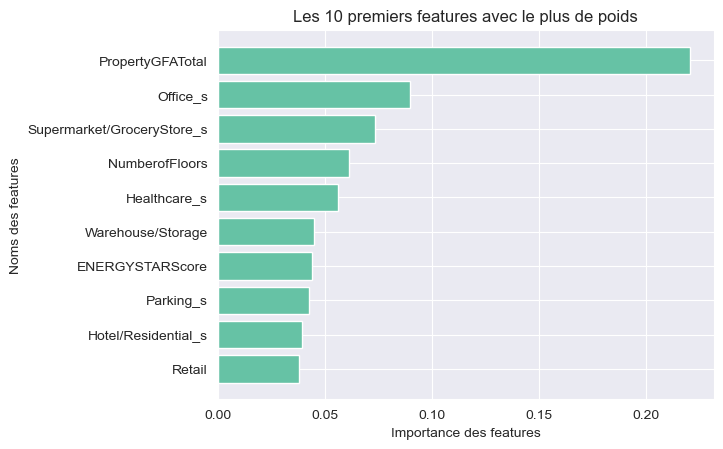

In [38]:
#pour retrouver les index
Xbisbis = data2.copy().drop(columns=['SiteEnergyUse_kBtu','TotalGHGEmissions'])
Xbisbis['ENERGYSTARScore']=ENERGYSTARScore
Xbisbis.drop(Xbisbis[Xbisbis['ENERGYSTARScore']=='unknown'].index,inplace=True)

top10_feature_indexes = np.argsort(feature_weights)[::-1][:10][::-1]
top10_feature_names = Xbisbis.columns[top10_feature_indexes]
top10_feature_weights = feature_weights[top10_feature_indexes]
plt.barh(top10_feature_names, top10_feature_weights)
plt.title("Les 10 premiers features avec le plus de poids")
plt.xlabel("Importance des features")
plt.ylabel("Noms des features")
plt.show()

In [39]:
resultats

,Modèle,RMSE,nRMSE,R2,MAPE
0,"ElasticNet(alpha=0.001, l1_ratio=0.675)",3611133.488,0.716,0.669,1.007
1,DummyRegressor(),6340829.028,1.258,0.004,2.826
2,LinearRegression(),3773933.598,0.748,0.609,0.981
3,"RandomForestRegressor(bootstrap=False, max_depth=80, max_features=10,\n min_samples_split=8, n_estimators=300)",3506088.943,0.695,0.696,0.804
4,"SVR(C=100, epsilon=0.001, gamma=0.35)",6854078.079,1.359,0.167,1.280
5,"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=0.7, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=0.03, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=5, max_leaves=None,\n min_child_weight=4, missing=nan, monotone_constraints=None,\n n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,\n objective='reg:linear', ...)",3519258.249,0.698,0.693,0.795
6,XGboost + ENERGYSTARScore,2569723.949,0.510,0.844,0.425
7,XGboost + sans ENERGYSTARScore,3305370.579,0.656,0.731,0.620


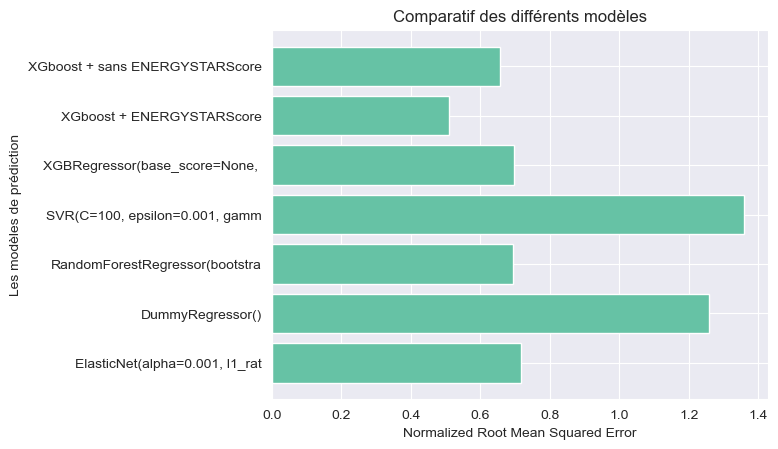

In [43]:
plt.barh(resultats.Modèle.drop(2).str.slice(0,30), resultats.nRMSE.drop(2))
plt.title("Comparatif des différents modèles")
plt.xlabel("Normalized Root Mean Squared Error")
plt.ylabel("Les modèles de prédiction")
plt.show()

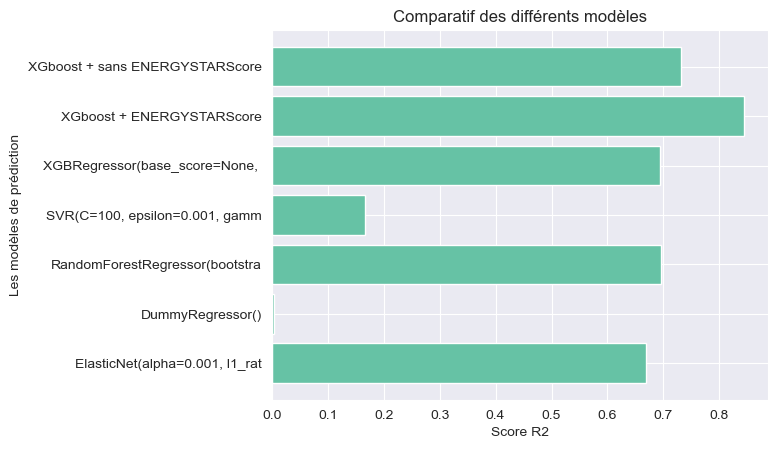

In [42]:
plt.barh(resultats.Modèle.drop(2).str.slice(0,30), resultats.R2.drop(2))
plt.title("Comparatif des différents modèles")
plt.xlabel("Score R2")
plt.ylabel('Les modèles de prédiction')
plt.show()